In [1]:
import pandas as pd
import numpy as np

In [2]:
fips = '36061'

In [3]:
# Cleaning and retrieving mobility data

mob = pd.read_csv('applemobilitydata/applemobilitycleaned_county.csv')
mob = mob.loc[mob['fips'] == float(fips)]
cols = [0,2,3]
mob = mob.drop(mob.columns[cols], axis=1)
mob

,fips,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,2020-01-20,2020-01-21,...,2020-05-18,2020-05-19,2020-05-20,2020-05-21,2020-05-22,2020-05-23,2020-05-24,2020-05-25,2020-05-26,2020-05-27
868,36061.0,100.0,94.86,99.23,103.35,122.96,115.13,107.98,87.73,90.64,...,30.37,31.91,32.87,34.93,39.5,30.65,33.82,32.03,36.65,37.29


In [4]:
# Cleaning and retrieving symptoms data

sym = pd.read_csv('covidsymptoms/covidsymptoms_google.csv')
sym = sym.loc[sym['fips'] == float(fips)]
cols = [0,2,3]
sym = sym.drop(sym.columns[cols], axis=1)
sym

,fips,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21,...,2020-05-04,2020-05-05,2020-05-06,2020-05-07,2020-05-08,2020-05-09,2020-05-10,2020-05-11,2020-05-12,2020-05-13
30,36061,23.942948,22.669515,21.310849,19.385167,17.659743,18.039532,18.78854,20.028444,19.952245,...,12.369208,11.85822,11.981621,11.122302,10.857461,11.373938,11.499215,10.729665,10.321903,10.541343


In [5]:
# Cleaning and retrieving demographics data

dem = pd.read_csv('countydemographics/county_demographics.csv')
dem = dem.loc[dem['fips'] == float(fips)]
cols = [0,2,3,4,5,6,9,10,11]
dem = dem.drop(dem.columns[cols], axis=1)
dem

,fips,median_age,population,Density per square mile of land area
1857,36061,37.3,1632480,69468.4


In [6]:
# Cleaning and retrieving testing rate data

tes = pd.read_csv('testingrates/testing_rates_county.csv')
tes = tes.loc[tes['fips'] == float(fips)]
cols = [0]
tes = tes.drop(tes.columns[cols], axis=1)
tes

,fips,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,...,2020-05-20,2020-05-21,2020-05-22,2020-05-23,2020-05-24,2020-05-25,2020-05-26,2020-05-27,2020-05-28,2020-05-29
1856,36061,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.019582,0.019074,0.018617,0.018129,0.017697,0.017354,0.017065,0.016764,0.01626,0.015763


In [7]:
# Cleaning and retrieving case data

cas = pd.read_csv('covidstats/confirmed_cases_county.csv')
cas = cas.loc[cas['fips'] == float(fips)]
cols = [0]
cas = cas.drop(cas.columns[cols], axis=1)
cas

,fips,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,...,2020-05-19,2020-05-20,2020-05-21,2020-05-22,2020-05-23,2020-05-24,2020-05-25,2020-05-26,2020-05-27,2020-05-28
1858,36061,0,0,0,0,0,0,0,0,0,...,97541.0,97009.0,98666.0,97818.0,99448.0,98675.0,100056.0,99245.0,100723.0,100328.0


In [8]:
newX = pd.concat([mob,sym])
newX = newX.reset_index()
newX = newX.drop(newX.columns[[0,1]], axis=1)

newY = pd.concat([cas])
newY = newY.reset_index()
newY = newY.drop(newY.columns[[0,1]], axis=1)

In [9]:
newX = newX.T
newY = newY.T
newX = newX.fillna(0)
newY = newY.fillna(0)

In [10]:
X = newX[[0,1]]
y = newY[[0]]

In [11]:
# Moving averages

X[0] = X[0].rolling(window=14).mean().dropna()
X[1] = X[1].rolling(window=9).mean().dropna()

#y[1] = y[1].shift(14).dropna()
X = X[X.index.isin(y.index)]
y = y[y.index.isin(X.index)]
X = X.fillna(0)
y = y.fillna(0)

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn import metrics

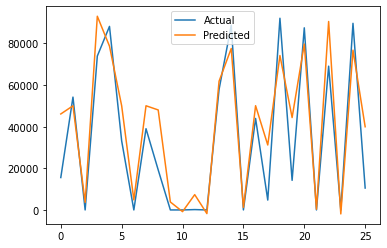

In [13]:
regressor = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
model = regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
df = pd.DataFrame({'Actual': y_test.to_numpy().flatten(), 'Predicted': y_pred.flatten()})
df.plot()

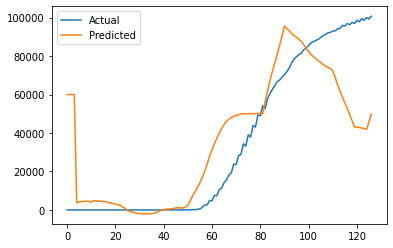

In [14]:
y_pred = regressor.predict(X)
df = pd.DataFrame({'Actual': y.to_numpy().flatten(), 'Predicted': y_pred.flatten()})
df.plot()

results = model_selection.cross_val_score(model, y_pred, y_test, scoring = 'r2')
print(f'r^2: {results.mean()}, {results.std()}')

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))